<a href="https://colab.research.google.com/github/RummanAli/FYP2022-KnowledgeVision/blob/main/G1020_KFoldCrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-fold-Cross-Validation

In [25]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import numpy as np
import pandas as pd

In [26]:
df = pd.read_csv('/content/drive/MyDrive/g1020-polygons/G1020.csv')
partition = {'train': [],'validation' : []}
for i in range(900):
  partition['train'].append(df['imageID'][i])
for i in range(900,1020):
  partition['validation'].append(df['imageID'][i])
labels = dict((val, out ) for val,out in zip(df['imageID'],df['binaryLabels']))

In [27]:
labels2 = dict((val, out ) for val,out in zip(df['patientID'],df['binaryLabels']))

In [28]:
patient_labels = []
for x in df['patientID'].unique():
  patient_labels.append(labels2[x])

In [29]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
skf = StratifiedKFold(n_splits=6, random_state=42, shuffle=True)
train_folds = []
val_folds = []
for train_index, val_index in skf.split(df['patientID'].unique(), patient_labels):
  train_folds.append(train_index)
  val_folds.append(val_index)
  

In [30]:
folds = []
for train_fold,val_fold in zip(train_folds,val_folds):
  fold = {'train': [],'validation' : []}
  for x in train_fold:
    a = df['patientID'].unique()[x]
    index = df.index[df['patientID']== a].tolist()
    for img in index:
      fold['train'].append(df['imageID'][img])

  for y in val_fold:
    a = df['patientID'].unique()[y]
    index = df.index[df['patientID']== a].tolist()
    for img in index:
      fold['validation'].append(df['imageID'][img])
  folds.append(fold)

# Model by Author

In [7]:
from torchvision.models import Inception3
from fastai.vision import *
import os
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import matplotlib
from sklearn.metrics import classification_report

In [10]:
def load_model():
  v3 = Inception3(2,init_weights=True)
  state_dict = torch.load('/content/drive/MyDrive/bestmodel.pth',map_location = 'cpu')
  v3.load_state_dict(state_dict['model'])
  return v3


def get_outputs(v3,fold):
  data_path = '/content/drive/MyDrive/g1020-polygons'
  outputs = []
  for images in fold['validation']:
    image_path = os.path.join(data_path,images[:-4]+'.png')
    img = Image.open(image_path)
    img.load()
    background = Image.new("RGB", img.size, (255, 255, 255))
    background.paste(img, mask = img.split()[3])
    img = background.resize((299, 299), Image.ANTIALIAS)
    img = np.expand_dims(np.array(img),axis = 0)
    img = np.reshape(img,(1,3,299,299))
    v3.eval()
    img = torch.tensor(img)
    out = torch.argmax(torch.exp(v3(img.float())))
    outputs.append(out)
  return outputs

In [11]:
for i in range(6):
  outputs = get_outputs(load_model(),folds[i])
  y_true = []
  for x in folds[i]['validation']:
    y_true.append(labels[str(x)])
  print(classification_report(y_true,outputs))

              precision    recall  f1-score   support

           0       0.75      0.17      0.27       127
           1       0.27      0.85      0.41        47

    accuracy                           0.35       174
   macro avg       0.51      0.51      0.34       174
weighted avg       0.62      0.35      0.31       174

              precision    recall  f1-score   support

           0       0.82      0.25      0.38       132
           1       0.23      0.81      0.35        36

    accuracy                           0.37       168
   macro avg       0.53      0.53      0.37       168
weighted avg       0.70      0.37      0.38       168

              precision    recall  f1-score   support

           0       0.67      0.25      0.36       122
           1       0.33      0.75      0.46        61

    accuracy                           0.42       183
   macro avg       0.50      0.50      0.41       183
weighted avg       0.56      0.42      0.39       183

              preci

In [ ]:
print(classification_report(y_true,outputs))

              precision    recall  f1-score   support

           0       0.75      0.17      0.27       127
           1       0.27      0.85      0.41        47

    accuracy                           0.35       174
   macro avg       0.51      0.51      0.34       174
weighted avg       0.62      0.35      0.31       174



# Pre-Trained Model

In [31]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Add, Reshape,Conv2D,MaxPooling2D,ZeroPadding2D,experimental,AveragePooling2D,Concatenate,Dropout,Activation
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import keras
import tensorflow
from PIL import Image

In [ ]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=1, dim=(299,299), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = Image.open('/content/drive/MyDrive/g1020-polygons/' + ID[:-4] + '.png')
            background = Image.new("RGB", img.size, (255, 255, 255))
            background.paste(img, mask = img.split()[3])
            X[i,] = np.array(background.resize((299, 299), Image.ANTIALIAS))
            # Store class
            y[i] = self.labels[ID]

        return X, tensorflow.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
def pre_trained_model():
    input = Input((299,299,3))
    c1l1  = Conv2D(32,3,(1,1),padding = 'same',activation='relu')(input)
    c1l2  = Conv2D(32,3,(1,1),padding = 'same',activation='relu')(c1l1)
    ces2  = Add()([c1l2, c1l1])
    c1l3  = Conv2D(32,3,(1,1),padding = 'same',activation='relu')(c1l2)
    ces3  = Add()([c1l3, ces2])
    ces3  = Flatten()(c1l3)
    ces3  = Dense(2)(ces3)
    ces3  = Activation('softmax')(ces3)
    return Model(inputs=input, outputs=ces3)

In [ ]:
for i in range(6):
  #y_true_train = []
  #for x in folds[i]['train']:
  #  y_true_train.append(labels[str(x)])
  #y_true_test = []
  #for x in folds[i]['validation']:
  #  y_true_test.append(labels[str(x)])
  training_generator = DataGenerator(folds[i]['train'], labels)
  validation_generator = DataGenerator(folds[i]['validation'], labels)
  opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
  pretrained_model = pre_trained_model()
  pretrained_model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
  history = pretrained_model.fit_generator(training_generator,validation_data=validation_generator,epochs = 20)
  tf.keras.models.save_model(pretrained_model,'drive/MyDrive/pretrained_fold'+str(i))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/20
846/846 [==============================] - 309s 364ms/step - loss: 336.3771 - accuracy: 0.6584 - val_loss: 0.5906 - val_accuracy: 0.7241
Epoch 2/20
846/846 [==============================] - 37s 43ms/step - loss: 1.5885 - accuracy: 0.6986 - val_loss: 0.6057 - val_accuracy: 0.7299
Epoch 3/20
846/846 [==============================] - 36s 43ms/step - loss: 9.4673 - accuracy: 0.7009 - val_loss: 0.6192 - val_accuracy: 0.7299
Epoch 4/20
846/846 [==============================] - 36s 43ms/step - loss: 19.0221 - accuracy: 0.7033 - val_loss: 0.6762 - val_accuracy: 0.6897
Epoch 5/20
846/846 [==============================] - 37s 43ms/step - loss: 12.9867 - accuracy: 0.7021 - val_loss: 0.8426 - val_accuracy: 0.7126
Epoch 6/20
846/846 [==============================] - 37s 44ms/step - loss: 4.5137 - accuracy: 0.7092 - val_loss: 1.0510 - val_accuracy: 0.7011
Epoch 7/20
846/846 [==============================] - 37s 43ms/step - loss: 2.1221 - accuracy: 0.7116 - val_loss: 0.6556 - val_acc

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


852/852 [==============================] - 38s 44ms/step - loss: 515.8306 - accuracy: 0.6620 - val_loss: 0.6301 - val_accuracy: 0.7798
Epoch 2/20
852/852 [==============================] - 37s 43ms/step - loss: 1.5359 - accuracy: 0.6878 - val_loss: 0.5500 - val_accuracy: 0.7857
Epoch 3/20
852/852 [==============================] - 36s 43ms/step - loss: 34.2718 - accuracy: 0.6960 - val_loss: 0.5206 - val_accuracy: 0.7857
Epoch 4/20
852/852 [==============================] - 36s 43ms/step - loss: 1.2874 - accuracy: 0.6913 - val_loss: 0.5817 - val_accuracy: 0.7857
Epoch 5/20
852/852 [==============================] - 37s 43ms/step - loss: 11.5605 - accuracy: 0.6878 - val_loss: 0.5189 - val_accuracy: 0.7857
Epoch 6/20
852/852 [==============================] - 37s 44ms/step - loss: 13.4791 - accuracy: 0.6901 - val_loss: 0.6366 - val_accuracy: 0.7857
Epoch 7/20
852/852 [==============================] - 37s 43ms/step - loss: 9.2488 - accuracy: 0.6866 - val_loss: 0.5635 - val_accuracy: 0.785

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


837/837 [==============================] - 37s 44ms/step - loss: 296.9763 - accuracy: 0.6714 - val_loss: 0.6593 - val_accuracy: 0.6667
Epoch 2/20
837/837 [==============================] - 37s 44ms/step - loss: 1.2613 - accuracy: 0.7145 - val_loss: 0.6379 - val_accuracy: 0.6667
Epoch 3/20
837/837 [==============================] - 36s 43ms/step - loss: 2.2415 - accuracy: 0.7180 - val_loss: 0.6371 - val_accuracy: 0.6667
Epoch 4/20
837/837 [==============================] - 36s 43ms/step - loss: 42.6044 - accuracy: 0.7097 - val_loss: 0.6375 - val_accuracy: 0.6667
Epoch 5/20
837/837 [==============================] - 36s 43ms/step - loss: 18.8886 - accuracy: 0.7157 - val_loss: 0.6328 - val_accuracy: 0.6667
Epoch 6/20
837/837 [==============================] - 37s 44ms/step - loss: 5.1892 - accuracy: 0.7204 - val_loss: 0.6903 - val_accuracy: 0.6612
Epoch 7/20
837/837 [==============================] - 36s 43ms/step - loss: 19.3331 - accuracy: 0.7121 - val_loss: 0.6331 - val_accuracy: 0.666

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


847/847 [==============================] - 38s 44ms/step - loss: 396.4515 - accuracy: 0.6600 - val_loss: 0.6386 - val_accuracy: 0.7110
Epoch 2/20
847/847 [==============================] - 37s 44ms/step - loss: 1.1206 - accuracy: 0.7072 - val_loss: 0.6195 - val_accuracy: 0.7110
Epoch 3/20
847/847 [==============================] - 37s 43ms/step - loss: 14.2060 - accuracy: 0.6848 - val_loss: 0.6053 - val_accuracy: 0.7110
Epoch 4/20
847/847 [==============================] - 36s 43ms/step - loss: 5.4565 - accuracy: 0.6989 - val_loss: 0.6134 - val_accuracy: 0.7110
Epoch 5/20
847/847 [==============================] - 37s 43ms/step - loss: 8.8344 - accuracy: 0.6860 - val_loss: 0.7340 - val_accuracy: 0.6185
Epoch 6/20
847/847 [==============================] - 37s 43ms/step - loss: 1.9954 - accuracy: 0.6895 - val_loss: 0.6509 - val_accuracy: 0.7052
Epoch 7/20
847/847 [==============================] - 37s 44ms/step - loss: 3.8080 - accuracy: 0.7025 - val_loss: 0.6537 - val_accuracy: 0.7110


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


858/858 [==============================] - 37s 42ms/step - loss: 286.8394 - accuracy: 0.6760 - val_loss: 0.6247 - val_accuracy: 0.6975
Epoch 2/20
858/858 [==============================] - 36s 42ms/step - loss: 29.6026 - accuracy: 0.6970 - val_loss: 0.6362 - val_accuracy: 0.6975
Epoch 3/20
858/858 [==============================] - 37s 43ms/step - loss: 1.5409 - accuracy: 0.7016 - val_loss: 14.7807 - val_accuracy: 0.6975
Epoch 4/20
858/858 [==============================] - 36s 42ms/step - loss: 1.1698 - accuracy: 0.7086 - val_loss: 0.7041 - val_accuracy: 0.6914
Epoch 5/20
858/858 [==============================] - 36s 42ms/step - loss: 16.1500 - accuracy: 0.6993 - val_loss: 0.9548 - val_accuracy: 0.6975
Epoch 6/20
858/858 [==============================] - 36s 42ms/step - loss: 12.2267 - accuracy: 0.7098 - val_loss: 0.9776 - val_accuracy: 0.6914
Epoch 7/20
858/858 [==============================] - 36s 42ms/step - loss: 4.6099 - accuracy: 0.7110 - val_loss: 0.6114 - val_accuracy: 0.70

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


860/860 [==============================] - 38s 44ms/step - loss: 520.1136 - accuracy: 0.6744 - val_loss: 0.6383 - val_accuracy: 0.6687
Epoch 2/20
860/860 [==============================] - 37s 43ms/step - loss: 3.8614 - accuracy: 0.7093 - val_loss: 0.6378 - val_accuracy: 0.6687
Epoch 3/20
860/860 [==============================] - 37s 42ms/step - loss: 8.8954 - accuracy: 0.7093 - val_loss: 0.6416 - val_accuracy: 0.6687
Epoch 4/20
860/860 [==============================] - 37s 43ms/step - loss: 11.7663 - accuracy: 0.7093 - val_loss: 0.6629 - val_accuracy: 0.6687
Epoch 5/20
860/860 [==============================] - 37s 43ms/step - loss: 7.5127 - accuracy: 0.7128 - val_loss: 0.7475 - val_accuracy: 0.6562
Epoch 6/20
860/860 [==============================] - 37s 43ms/step - loss: 3.0622 - accuracy: 0.7174 - val_loss: 0.6680 - val_accuracy: 0.6687
Epoch 7/20
860/860 [==============================] - 37s 43ms/step - loss: 18.8927 - accuracy: 0.7105 - val_loss: 0.8294 - val_accuracy: 0.6562

In [ ]:
def get_outputs(model,fold):
  outputs = []
  y_true = []
  model = tf.keras.models.load_model('drive/MyDrive/pretrained_fold'+str(model))
  for x in fold['validation']:
    y_true.append(labels[str(x)])
    img = Image.open('/content/drive/MyDrive/g1020-polygons/' + x[:-4] + '.png')
    background = Image.new("RGB", img.size, (255, 255, 255))
    background.paste(img, mask = img.split()[3])
    img = np.expand_dims(np.array(background.resize((299, 299), Image.ANTIALIAS)),axis = 0)
    outputs.append(np.argmax(model(img)))
    #print(outputs)
  return outputs,y_true

In [ ]:
for i in range(6):
  outputs,y_true = get_outputs(i,folds[i])
  print(classification_report(y_true,outputs))

              precision    recall  f1-score   support

           0       0.73      0.99      0.84       127
           1       0.50      0.02      0.04        47

    accuracy                           0.73       174
   macro avg       0.62      0.51      0.44       174
weighted avg       0.67      0.73      0.63       174

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       132
           1       0.23      0.08      0.12        36

    accuracy                           0.74       168
   macro avg       0.51      0.50      0.49       168
weighted avg       0.67      0.74      0.69       168



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.67      1.00      0.80       122
           1       0.00      0.00      0.00        61

    accuracy                           0.67       183
   macro avg       0.33      0.50      0.40       183
weighted avg       0.44      0.67      0.53       183

              precision    recall  f1-score   support

           0       0.72      0.97      0.83       123
           1       0.50      0.08      0.14        50

    accuracy                           0.71       173
   macro avg       0.61      0.52      0.48       173
weighted avg       0.66      0.71      0.63       173

              precision    recall  f1-score   support

           0       0.25      0.01      0.02       113
           1       0.29      0.94      0.44        49

    accuracy                           0.29       162
   macro avg       0.27      0.47      0.23       162
weighted avg       0.26      0.29      0.15       162

              preci

# PreTrained Resnet

In [1]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('/content/drive/MyDrive/g1020-polygons/G1020.csv')
partition = {'train': [],'test' : []}
for i in range(900):
  partition['train'].append(df['imageID'][i])
for i in range(900,1020):
  partition['test'].append(df['imageID'][i])
labels = dict((val, out ) for val,out in zip(df['imageID'],df['binaryLabels']))

In [3]:
labels2 = dict((val, out ) for val,out in zip(df['patientID'],df['binaryLabels']))

In [4]:
patient_labels = []
for x in df['patientID'].unique():
  patient_labels.append(labels2[x])

In [5]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
skf = StratifiedKFold(n_splits=6, random_state=42, shuffle=True)
train_folds = []
val_folds = []
for train_index, val_index in skf.split(df['patientID'].unique(), patient_labels):
  train_folds.append(train_index)
  val_folds.append(val_index)
  

In [6]:
folds = []
for train_fold,val_fold in zip(train_folds,val_folds):
  fold = {'train': [],'test' : []}
  for x in train_fold:
    a = df['patientID'].unique()[x]
    index = df.index[df['patientID']== a].tolist()
    for img in index:
      fold['train'].append(df['imageID'][img])

  for y in val_fold:
    a = df['patientID'].unique()[y]
    index = df.index[df['patientID']== a].tolist()
    for img in index:
      fold['test'].append(df['imageID'][img])
  folds.append(fold)

In [7]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn
from PIL import Image


In [8]:
class DermNetDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, list_IDs, labels,transforms, batch_size=16, dim=(299,299), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.transform = transforms
        self.n_channels = n_channels
        self.n_classes = n_classes

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.list_IDs[idx]
        img = Image.open('/content/drive/MyDrive/g1020-polygons/' + img_name[:-4] + '.png')
        background = Image.new("RGB", img.size, (255, 255, 255))
        background.paste(img, mask = img.split()[3])
        label = labels[img_name]
        sample = {'image': background, 'label': label}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample['image'],sample['label']

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn
from PIL import Image


data_dir = "archive"
num_classes = 2
batch_size = 16
def train_model(model, dataloaders, criterion, optimizer, num_epochs=20):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            #print(dataloaders[phase].classes())
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'test':
                val_acc_history.append(epoch_acc)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history





model_ft = models.densenet169(pretrained=True)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, num_classes)
input_size = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: DermNetDataset(folds[4]['train'],labels, data_transforms[x]) for x in ['train', 'test']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=20)
torch.save(model_ft.state_dict(),'drive/MyDrive/torch_densenet_best.pth')

Epoch 0/19
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6455 Acc: 0.6632
test Loss: 0.8503 Acc: 0.7121
Epoch 1/19
----------
train Loss: 0.6622 Acc: 0.6538
test Loss: 0.5950 Acc: 0.7179
Epoch 2/19
----------
train Loss: 0.6165 Acc: 0.6911
test Loss: 0.6328 Acc: 0.7145
Epoch 3/19
----------
train Loss: 0.6127 Acc: 0.6970
test Loss: 0.7291 Acc: 0.7121
Epoch 4/19
----------
train Loss: 0.6041 Acc: 0.6993
test Loss: 0.5573 Acc: 0.7179
Epoch 5/19
----------
train Loss: 0.6336 Acc: 0.6830
test Loss: 0.6196 Acc: 0.7133
Epoch 6/19
----------
train Loss: 0.6358 Acc: 0.6900
test Loss: 0.5716 Acc: 0.7203
Epoch 7/19
----------
train Loss: 0.6051 Acc: 0.6807
test Loss: 0.5033 Acc: 0.7564
Epoch 8/19
----------
train Loss: 0.5886 Acc: 0.7040
test Loss: 0.5563 Acc: 0.7203
Epoch 9/19
----------
train Loss: 0.5626 Acc: 0.7343
test Loss: 0.5619 Acc: 0.7354
Epoch 10/19
----------
train Loss: 0.5771 Acc: 0.7296
test Loss: 0.4458 Acc: 0.8054
Epoch 11/19
----------
train Loss: 0.5701 Acc: 0.7203
test Loss: 0.4403 Acc: 0.7972
Epoch 12/19
----------
t

In [9]:
from torchvision.models import densenet169
from fastai.vision import *
import os
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import matplotlib
from sklearn.metrics import classification_report

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
def load_model():
  dn = models.densenet169(pretrained=False)
  num_ftrs = dn.classifier.in_features
  dn.classifier = nn.Linear(num_ftrs, 2)
  dn.load_state_dict(torch.load('/content/drive/MyDrive/torch_densenet_best.pth'))
  return dn


def get_outputs(dn,fold):
  data_path = '/content/drive/MyDrive/g1020-polygons'
  outputs = []
  for images in fold['test']:
    image_path = os.path.join(data_path,images[:-4]+'.png')
    img = Image.open(image_path)
    img.load()
    background = Image.new("RGB", img.size, (255, 255, 255))
    background.paste(img, mask = img.split()[3])
    img = data_transforms['test'](background)
    img = torch.unsqueeze(img,axis = 0)
    #img = np.reshape(img,(1,3,299,299))
    dn.eval()
    #img = torch.tensor(img)
    #print(dn(img))
    out = torch.argmax(dn(img))
    outputs.append(out)
  return outputs

def save_outputs(dn,fold,directory):
    data_path = '/content/drive/MyDrive/g1020-polygons'
    outputs = []
    for phase in ['train' , 'test']:
      for images in fold[phase]:
        image_path = os.path.join(data_path,images[:-4]+'.png')
        img = Image.open(image_path)
        img.load()
        background = Image.new("RGB", img.size, (255, 255, 255))
        background.paste(img, mask = img.split()[3])
        img = data_transforms['test'](background)
        img = torch.unsqueeze(img,axis = 0)
        dn.eval()
        out = dn(img).detach().cpu().numpy()
        np.save(os.path.join(directory,images[:-4]+'.npy'),out)

In [11]:
outputs = get_outputs(load_model(),folds[4])
y_true = []
for x in folds[4]['test']:
  y_true.append(labels[str(x)])
print(classification_report(y_true,outputs))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76       113
           1       0.41      0.33      0.36        49

    accuracy                           0.65       162
   macro avg       0.57      0.56      0.56       162
weighted avg       0.63      0.65      0.64       162



In [12]:
save_outputs(load_model(),folds[4],'drive/MyDrive/knowledge2_g1020_best')

# Knowledge Incorporated Model

In [15]:
import numpy as np
import keras
import tensorflow
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=2, dim=(299,299), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        #X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        k = np.empty((self.batch_size,2))
        k2 = np.empty((self.batch_size,2))
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = Image.open('/content/drive/MyDrive/g1020-polygons/' + ID[:-4] + '.png')
            background = Image.new("RGB", img.size, (255, 255, 255))
            background.paste(img, mask = img.split()[3])
            #X[i,] = np.array(background.resize((299, 299), Image.ANTIALIAS))

            # Store class
            y[i] = self.labels[ID]
            k[i] = np.load('/content/drive/MyDrive/knowledge_g1020_best/'+str(ID[:-4])+'.npy',allow_pickle= True)
            k2[i]= np.load('/content/drive/MyDrive/knowledge2_g1020_best/'+str(ID[:-4])+'.npy',allow_pickle= True)
        return [k2,k], tensorflow.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [16]:
def knowledge_incorporated_model():#pretrained_model):    
    inputA = Input((2))
    inputB = Input((2))
    inputA = Activation('softmax')(inputA)
    inputB = Activation('softmax')(inputB)
    l1    = Add()([inputA,inputB])
    l1    = Dense(32)(l1)
    l2    = Activation('relu')(l1)
    l4    = Dense(64)(l2)
    l5    = Activation('relu')(l4)
    l6    = Dense(2)(l5)
    l7    = Activation('softmax')(l6)
    l8    = Add()([l7,inputB])
    l9    = Activation('softmax')(l8)
    return Model(inputs=[inputA, inputB], outputs=l9)

In [21]:
'''
for i in range(6):
  training_generator_final = DataGenerator(folds[i]['train'], labels)
  validation_generator_final = DataGenerator(folds[i]['validation'], labels)
  pretrained_model = tf.keras.models.load_model('drive/MyDrive/pretrained_fold'+str(i))
  opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
  final_model = knowledge_incorporated_model(pretrained_model)
  final_model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
  history_final = final_model.fit_generator(training_generator_final,validation_data=validation_generator_final,epochs = 20)
  tf.keras.models.save_model(final_model,'drive/MyDrive/G1020_knowledge_incorporated_fold'+str(i))
'''
training_generator = DataGenerator(folds[4]['train'], labels)
validation_generator = DataGenerator(folds[4]['test'], labels)
opt_rms = tensorflow.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
final_model = knowledge_incorporated_model()
final_model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history_final = final_model.fit_generator(training_generator,validation_data=validation_generator,epochs = 20)
tf.keras.models.save_model(final_model,'drive/MyDrive/G1020_knowledge_incorporated_fold4(dense+inception)')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
429/429 [==============================] - 483s 1s/step - loss: 4.0913 - accuracy: 0.4114 - val_loss: 3.4255 - val_accuracy: 0.4383
Epoch 2/20
429/429 [==============================] - 17s 39ms/step - loss: 4.0902 - accuracy: 0.4114 - val_loss: 3.4250 - val_accuracy: 0.4383
Epoch 3/20
429/429 [==============================] - 16s 38ms/step - loss: 4.0902 - accuracy: 0.4114 - val_loss: 3.4249 - val_accuracy: 0.4383
Epoch 4/20
429/429 [==============================] - 17s 39ms/step - loss: 4.0902 - accuracy: 0.4114 - val_loss: 3.4246 - val_accuracy: 0.4383
Epoch 5/20
429/429 [==============================] - 17s 39ms/step - loss: 4.0902 - accuracy: 0.4114 - val_loss: 3.4250 - val_accuracy: 0.4383
Epoch 6/20
429/429 [==============================] - 17s 39ms/step - loss: 4.0902 - accuracy: 0.4114 - val_loss: 3.4251 - val_accuracy: 0.4383
Epoch 7/20
429/429 [==============================] - 16s 38ms/step - loss: 4.0902 - accuracy: 0.4114 - val_loss: 3.4251 - val_accuracy: 

INFO:tensorflow:Assets written to: drive/MyDrive/G1020_knowledge_incorporated_fold4(dense+inception)/assets


INFO:tensorflow:Assets written to: drive/MyDrive/G1020_knowledge_incorporated_fold4(dense+inception)/assets


In [22]:
def knowledge_incorporated_model():#pretrained_model):    
    inputA = Input((2))
    inputB = Input((2))
    l1    = Add()([inputA,inputB])
    l1    = Dense(32)(l1)
    l2    = Activation('relu')(l1)
    l4    = Dense(64)(l2)
    l5    = Activation('relu')(l4)
    l6    = Dense(2)(l5)
    l8    = Add()([l6,inputB])
    l9    = Activation('softmax')(l8)
    return Model(inputs=[inputA, inputB], outputs=l9)

In [23]:
'''
for i in range(6):
  training_generator_final = DataGenerator(folds[i]['train'], labels)
  validation_generator_final = DataGenerator(folds[i]['validation'], labels)
  pretrained_model = tf.keras.models.load_model('drive/MyDrive/pretrained_fold'+str(i))
  opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
  final_model = knowledge_incorporated_model(pretrained_model)
  final_model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
  history_final = final_model.fit_generator(training_generator_final,validation_data=validation_generator_final,epochs = 20)
  tf.keras.models.save_model(final_model,'drive/MyDrive/G1020_knowledge_incorporated_fold'+str(i))
'''
training_generator = DataGenerator(folds[4]['train'], labels)
validation_generator = DataGenerator(folds[4]['test'], labels)
opt_rms = tensorflow.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
final_model = knowledge_incorporated_model()
final_model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history_final = final_model.fit_generator(training_generator,validation_data=validation_generator,epochs = 20)
tf.keras.models.save_model(final_model,'drive/MyDrive/G1020_knowledge_incorporated_fold4(dense+inception)_logits')

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


429/429 [==============================] - 19s 43ms/step - loss: 2.0956 - accuracy: 0.4744 - val_loss: 1.3683 - val_accuracy: 0.5617
Epoch 2/20
429/429 [==============================] - 17s 39ms/step - loss: 1.8708 - accuracy: 0.4674 - val_loss: 1.4821 - val_accuracy: 0.6235
Epoch 3/20
429/429 [==============================] - 17s 39ms/step - loss: 1.8267 - accuracy: 0.4848 - val_loss: 1.8518 - val_accuracy: 0.4321
Epoch 4/20
429/429 [==============================] - 17s 39ms/step - loss: 1.8573 - accuracy: 0.4522 - val_loss: 1.5518 - val_accuracy: 0.6358
Epoch 5/20
429/429 [==============================] - 17s 39ms/step - loss: 1.8325 - accuracy: 0.4767 - val_loss: 1.7242 - val_accuracy: 0.6605
Epoch 6/20
429/429 [==============================] - 17s 39ms/step - loss: 1.8150 - accuracy: 0.4790 - val_loss: 1.5730 - val_accuracy: 0.5494
Epoch 7/20
429/429 [==============================] - 17s 40ms/step - loss: 1.7956 - accuracy: 0.4709 - val_loss: 1.5169 - val_accuracy: 0.5988
Epo

INFO:tensorflow:Assets written to: drive/MyDrive/G1020_knowledge_incorporated_fold4(dense+inception)_logits/assets


In [24]:
def knowledge_incorporated_model():#pretrained_model):    
    inputA = Input((2))
    inputB = Input((2))
    inputA = Activation('softmax')(inputA)
    inputB = Activation('softmax')(inputB)
    l1    = Add()([inputA,inputB])
    l1    = Dense(32)(l1)
    l2    = Activation('relu')(l1)
    l4    = Dense(64)(l2)
    l5    = Activation('relu')(l4)
    l6    = Dense(2)(l5)
    l7    = Activation('softmax')(l6)
    l8    = Add()([l7,inputA])
    l9    = Activation('softmax')(l8)
    return Model(inputs=[inputA, inputB], outputs=l9)

In [25]:
'''
for i in range(6):
  training_generator_final = DataGenerator(folds[i]['train'], labels)
  validation_generator_final = DataGenerator(folds[i]['validation'], labels)
  pretrained_model = tf.keras.models.load_model('drive/MyDrive/pretrained_fold'+str(i))
  opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
  final_model = knowledge_incorporated_model(pretrained_model)
  final_model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
  history_final = final_model.fit_generator(training_generator_final,validation_data=validation_generator_final,epochs = 20)
  tf.keras.models.save_model(final_model,'drive/MyDrive/G1020_knowledge_incorporated_fold'+str(i))
'''
training_generator = DataGenerator(folds[4]['train'], labels)
validation_generator = DataGenerator(folds[4]['test'], labels)
opt_rms = tensorflow.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
final_model = knowledge_incorporated_model()
final_model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history_final = final_model.fit_generator(training_generator,validation_data=validation_generator,epochs = 20)
tf.keras.models.save_model(final_model,'drive/MyDrive/G1020_knowledge_incorporated_fold4(dense+inception)_denseteacher_softmax')

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


429/429 [==============================] - 19s 44ms/step - loss: 0.2306 - accuracy: 0.9138 - val_loss: 0.8581 - val_accuracy: 0.7160
Epoch 2/20
429/429 [==============================] - 17s 39ms/step - loss: 0.2308 - accuracy: 0.9103 - val_loss: 0.8386 - val_accuracy: 0.6914
Epoch 3/20
429/429 [==============================] - 20s 46ms/step - loss: 0.2319 - accuracy: 0.9068 - val_loss: 0.8459 - val_accuracy: 0.6975
Epoch 4/20
429/429 [==============================] - 20s 46ms/step - loss: 0.2308 - accuracy: 0.9161 - val_loss: 0.8383 - val_accuracy: 0.6852
Epoch 5/20
429/429 [==============================] - 24s 56ms/step - loss: 0.2293 - accuracy: 0.9114 - val_loss: 0.8298 - val_accuracy: 0.6975
Epoch 6/20
429/429 [==============================] - 19s 45ms/step - loss: 0.2299 - accuracy: 0.9068 - val_loss: 0.8453 - val_accuracy: 0.7037
Epoch 7/20
429/429 [==============================] - 20s 46ms/step - loss: 0.2291 - accuracy: 0.8986 - val_loss: 0.8564 - val_accuracy: 0.7160
Epo

INFO:tensorflow:Assets written to: drive/MyDrive/G1020_knowledge_incorporated_fold4(dense+inception)_denseteacher_softmax/assets


INFO:tensorflow:Assets written to: drive/MyDrive/G1020_knowledge_incorporated_fold4(dense+inception)_denseteacher_softmax/assets


In [26]:
def knowledge_incorporated_model():#pretrained_model):    
    inputA = Input((2))
    inputB = Input((2))
    l1    = Add()([inputA,inputB])
    l1    = Dense(32)(l1)
    l2    = Activation('relu')(l1)
    l4    = Dense(64)(l2)
    l5    = Activation('relu')(l4)
    l6    = Dense(2)(l5)
    l8    = Add()([l6,inputA])
    l9    = Activation('softmax')(l8)
    return Model(inputs=[inputA, inputB], outputs=l9)

In [27]:
training_generator = DataGenerator(folds[4]['train'], labels)
validation_generator = DataGenerator(folds[4]['test'], labels)
opt_rms = tensorflow.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
final_model = knowledge_incorporated_model()
final_model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history_final = final_model.fit_generator(training_generator,validation_data=validation_generator,epochs = 20)
tf.keras.models.save_model(final_model,'drive/MyDrive/G1020_knowledge_incorporated_fold4(dense+inception)_logits_denseteacher')

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


429/429 [==============================] - 17s 39ms/step - loss: 0.2819 - accuracy: 0.8916 - val_loss: 0.8644 - val_accuracy: 0.6914
Epoch 2/20
429/429 [==============================] - 17s 41ms/step - loss: 0.2489 - accuracy: 0.9091 - val_loss: 0.9039 - val_accuracy: 0.6852
Epoch 3/20
429/429 [==============================] - 17s 39ms/step - loss: 0.2481 - accuracy: 0.9114 - val_loss: 0.9742 - val_accuracy: 0.6914
Epoch 4/20
429/429 [==============================] - 17s 39ms/step - loss: 0.2468 - accuracy: 0.9184 - val_loss: 0.9965 - val_accuracy: 0.6975
Epoch 5/20
429/429 [==============================] - 17s 39ms/step - loss: 0.2486 - accuracy: 0.9126 - val_loss: 1.0368 - val_accuracy: 0.6975
Epoch 6/20
429/429 [==============================] - 17s 39ms/step - loss: 0.2544 - accuracy: 0.9114 - val_loss: 1.1072 - val_accuracy: 0.7037
Epoch 7/20
429/429 [==============================] - 17s 39ms/step - loss: 0.2429 - accuracy: 0.9079 - val_loss: 1.0451 - val_accuracy: 0.6914
Epo

INFO:tensorflow:Assets written to: drive/MyDrive/G1020_knowledge_incorporated_fold4(dense+inception)_logits_denseteacher/assets


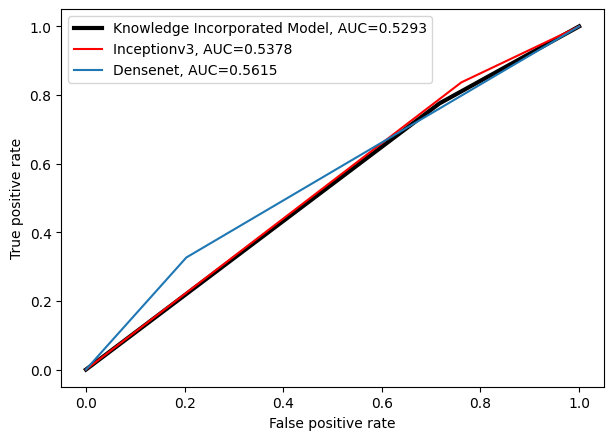

In [39]:
import matplotlib.pyplot as plt
from sklearn import metrics
model_list = ['G1020_knowledge_incorporated_fold4(dense+inception)_logits_denseteacher']
lab = ['Knowledge Incorporated Model']
plt.figure(0).clf()
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['figure.dpi'] = 100
for i,mod_type in enumerate(model_list):
  model = tf.keras.models.load_model('/content/drive/MyDrive/'+mod_type)
  y_true = []
  outputs = []
  know = []
  know2 = []
  for x in folds[4]['validation']:
    y_true.append(labels[str(x)])
    k = np.load('/content/drive/MyDrive/knowledge_g1020_best/'+str(x[:-4])+'.npy',allow_pickle= True)
    k2= np.load('/content/drive/MyDrive/knowledge2_g1020_best/'+str(x[:-4])+'.npy',allow_pickle= True)
    outputs.append(np.argmax(model([k,k2]),axis = -1))
  fpr, tpr, _ = metrics.roc_curve(y_true, outputs)
  auc = round(metrics.roc_auc_score(y_true, outputs), 4)
  plt.plot(fpr,tpr,label=lab[i]+", AUC="+str(auc),color='black',linewidth=3)


for x in folds[4]['validation']:
    k = np.load('/content/drive/MyDrive/knowledge_g1020_best/'+str(x[:-4])+'.npy',allow_pickle= True)
    k2= np.load('/content/drive/MyDrive/knowledge2_g1020_best/'+str(x[:-4])+'.npy',allow_pickle= True)
    know.append(k)
    know2.append(k2)
fpr, tpr, _ = metrics.roc_curve(y_true, np.argmax(know,axis = -1))
auc = round(metrics.roc_auc_score(y_true, np.argmax(know,axis = -1)), 4)
plt.plot(fpr,tpr,label="Inceptionv3"+", AUC="+str(auc),color='red')  
fpr, tpr, _ = metrics.roc_curve(y_true, np.argmax(know2,axis = -1))
auc = round(metrics.roc_auc_score(y_true, np.argmax(know2,axis = -1)), 4)
plt.plot(fpr,tpr,label="Densenet"+", AUC="+str(auc)) 

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc= "best")

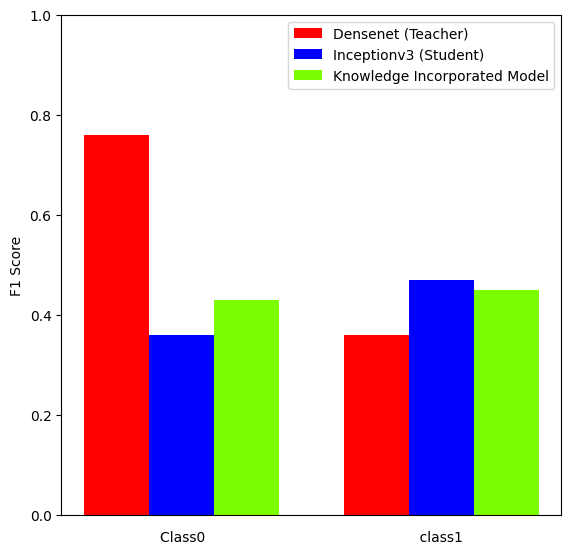

In [23]:
import numpy as np
import matplotlib.pyplot as plt
data = [[0.76,0.36],
[0.36, 0.47],
[0.43,0.45]]

X = np.arange(2)
fig = plt.figure()
plt.rcParams['figure.figsize'] = [5, 5]
plt.rcParams['figure.dpi'] = 100
ax = fig.add_axes([0,0,1,1])
ax.set_ylim([0, 1])
ax.bar(X + 0.00, data[0], color = 'r', width = 0.25, label = "Densenet (Teacher)")
ax.bar(X + 0.25, data[1], color = 'b', width = 0.25, label = "Inceptionv3 (Student)")
ax.bar(X + 0.50, data[2], color = 'lawngreen', width = 0.25, label = "Knowledge Incorporated Model")
ax.axes.xaxis.set_ticklabels([])
plt.tick_params(bottom=False)
plt.xlabel('Class0                                                 class1')
plt.ylabel('F1 Score')
plt.legend(loc= "best")

In [34]:
def report(model_path,fold):
  model = tf.keras.models.load_model(model_path)
  y_true = []
  outputs = []
  for x in fold['test']:
    y_true.append(labels[str(x)])
    output = model([np.load('/content/drive/MyDrive/knowledge_g1020_best/'+str(x[:-4])+'.npy'),np.load('/content/drive/MyDrive/knowledge2_g1020_best/'+str(x[:-4])+'.npy')])
    outputs.append(np.argmax(output,axis = -1))
  print(classification_report(y_true,outputs))

In [35]:
report('drive/MyDrive/G1020_knowledge_incorporated_fold4(dense+inception)',folds[4])
report('drive/MyDrive/G1020_knowledge_incorporated_fold4(dense+inception)_logits',folds[4])
report('drive/MyDrive/G1020_knowledge_incorporated_fold4(dense+inception)_denseteacher_softmax',folds[4])
report('drive/MyDrive/G1020_knowledge_incorporated_fold4(dense+inception)_logits_denseteacher',folds[4])

              precision    recall  f1-score   support

           0       0.73      0.93      0.82       113
           1       0.58      0.22      0.32        49

    accuracy                           0.72       162
   macro avg       0.66      0.58      0.57       162
weighted avg       0.69      0.72      0.67       162



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.70      1.00      0.82       113
           1       0.00      0.00      0.00        49

    accuracy                           0.70       162
   macro avg       0.35      0.50      0.41       162
weighted avg       0.49      0.70      0.57       162

              precision    recall  f1-score   support

           0       0.74      0.30      0.43       113
           1       0.32      0.76      0.45        49

    accuracy                           0.44       162
   macro avg       0.53      0.53      0.44       162
weighted avg       0.61      0.44      0.43       162

              precision    recall  f1-score   support

           0       0.74      0.28      0.41       113
           1       0.32      0.78      0.45        49

    accuracy                           0.43       162
   macro avg       0.53      0.53      0.43       162
weighted avg       0.62      0.43      0.42       162



In [13]:
a = np.load('/content/drive/MyDrive/knowledge2_g1020_best/image_0.npy',allow_pickle = True)

In [14]:
a.shape

(1, 2)

In [ ]:
for i in range(6):
  model = tf.keras.models.load_model('drive/MyDrive/G1020_knowledge_incorporated_fold'+str(i))
  y_true = []
  for x in folds[i]['validation']:
    y_true.append(labels[str(x)])
  validation_generator = DataGenerator(folds[i]['validation'], labels,batch_size=len(folds[i]['validation']))
  outputs = np.argmax(model.predict(validation_generator),axis = -1)
  print(outputs.shape)
  print(classification_report(y_true,outputs))


(174,)
              precision    recall  f1-score   support

           0       0.74      0.23      0.35       127
           1       0.27      0.79      0.41        47

    accuracy                           0.38       174
   macro avg       0.51      0.51      0.38       174
weighted avg       0.62      0.38      0.36       174

(168,)
              precision    recall  f1-score   support

           0       0.79      0.28      0.41       132
           1       0.21      0.72      0.33        36

    accuracy                           0.38       168
   macro avg       0.50      0.50      0.37       168
weighted avg       0.66      0.38      0.40       168

(183,)
              precision    recall  f1-score   support

           0       0.70      0.33      0.45       122
           1       0.35      0.72      0.47        61

    accuracy                           0.46       183
   macro avg       0.53      0.52      0.46       183
weighted avg       0.58      0.46      0.45       183

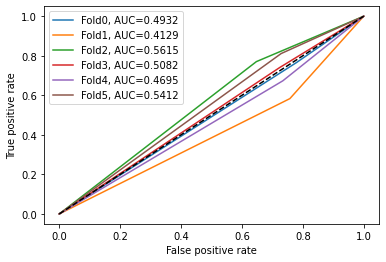

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics
plt.figure(0).clf()
for i in range(6):
  model = tf.keras.models.load_model('drive/MyDrive/G1020_knowledge_incorporated_fold'+str(i))
  y_true = []
  for x in folds[i]['validation']:
    y_true.append(labels[str(x)])
  validation_generator = DataGenerator(folds[i]['validation'], labels,batch_size=len(folds[i]['validation']))
  outputs = np.argmax(model.predict(validation_generator),axis = -1)
  fpr, tpr, _ = metrics.roc_curve(y_true, outputs)
  auc = round(metrics.roc_auc_score(y_true, outputs), 4)
  plt.plot(fpr,tpr,label="Fold"+str(i)+", AUC="+str(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc= "best")

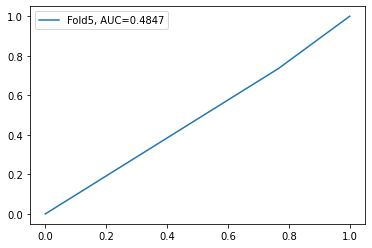

In [ ]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()
for i in range(6):
  viz = RocCurveDisplay.from_estimator(
          tf.keras.models.load_model('drive/MyDrive/G1020_knowledge_incorporated_fold'+str(i)),
          X[test],
          y[test],
          name="ROC fold {}".format(i),
          alpha=0.3,
          lw=1,
          ax=ax,
      )

# Knowledge Distillation

In [ ]:
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Add, Reshape,Conv2D,MaxPooling2D,ZeroPadding2D,experimental,AveragePooling2D,Concatenate,Dropout,Activation
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow
from PIL import Image

In [ ]:
def student_model():
    input = Input((299,299,3))
    c1l1  = Conv2D(32,3,(1,1),padding = 'same',activation='relu')(input)
    c1l2  = Conv2D(32,3,(1,1),padding = 'same',activation='relu')(c1l1)
    ces2  = Add()([c1l2, c1l1])
    c1l3  = Conv2D(32,3,(1,1),padding = 'same',activation='relu')(c1l2)
    ces3  = Add()([c1l3, ces2])
    ces3  = Flatten()(c1l3)
    ces3  = Dense(2)(ces3)
    ces3  = Activation('softmax')(ces3)
    return Model(inputs=input, outputs=ces3)

In [ ]:
import numpy as np
import keras
import tensorflow
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=16, dim=(299,299), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        k = np.empty((self.batch_size,2))
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = Image.open('/content/drive/MyDrive/g1020-polygons/' + ID[:-4] + '.png')
            background = Image.new("RGB", img.size, (255, 255, 255))
            background.paste(img, mask = img.split()[3])
            X[i,] = np.array(background.resize((299, 299), Image.ANTIALIAS))

            # Store class
            y[i] = self.labels[ID]
            k[i] = np.load('/content/drive/MyDrive/knowledge_g1020_best/'+str(ID[:-4])+'.npy',allow_pickle= True)

        return [X,k], tensorflow.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
for i in range(1,6):
  print('\n\nfold' + str(i) + '\n\n')  
  student = student_model()
  training_generator_final = DataGenerator(folds[i]['train'], labels)
  validation_generator_final = DataGenerator(folds[i]['validation'], labels)
  for epochs in range(20):
    for X,y in training_generator_final:
      x,k = X
      teacher_predictions = k
      student_loss_fn = tf.keras.losses.CategoricalCrossentropy()
      distillation_loss_fn = tf.keras.losses.KLDivergence()
      optimizer = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
      with tf.GradientTape() as tape:
          student_predictions = student(x, training=True)
          student_loss = student_loss_fn(y, student_predictions)
          distillation_loss = distillation_loss_fn(
              tf.nn.softmax(teacher_predictions / 3, axis=1),
              student_predictions
          )
          loss = 0.5 * student_loss + 0.5 * distillation_loss
      trainable_vars = student.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)
      optimizer.apply_gradients(zip(gradients, trainable_vars))
      metrics = [keras.metrics.SparseCategoricalAccuracy()]
      results = {m.name: m.result() for m in metrics}
      results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
      print('epoch: ' + str(epochs) + '/20')
      for name,value in results.items():
        print(name + ': ' + str(value)[10:18],end = ' ------ ')
      print('\n')
  tf.keras.models.save_model(student,'drive/MyDrive/G1020_student'+str(i))



fold1




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 46.88693 ------ distillation_loss: 2.758410 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 166553.6 ------ distillation_loss: 11.32229 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 6020.168 ------ distillation_loss: 10.26587 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 150055.3 ------ distillation_loss: 2.328705 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 200.1944 ------ distillation_loss: 12.76599 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 30729.56 ------ distillation_loss: 4.525665 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 15269.72 ------ distillation_loss: 10.44933 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 3359.896 ------ distillation_loss: 1.545037 ------ 

epoch: 0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 13.26019 ------ distillation_loss: 10.09697 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 107809.0 ------ distillation_loss: 2.819065 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 3441.970 ------ distillation_loss: 13.42853 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 30385.24 ------ distillation_loss: 4.84441, ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 860.595, ------ distillation_loss: 10.15111 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 1594.017 ------ distillation_loss: 4.249346 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 68.54922 ------ distillation_loss: 13.58157 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 379.4178 ------ distillation_loss: 3.864315 ------ 

epoch: 0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 67.49866 ------ distillation_loss: 2.224200 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 160950.6 ------ distillation_loss: 11.10521 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 7567.497 ------ distillation_loss: 4.935228 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 40071.61 ------ distillation_loss: 8.754084 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 206.4495 ------ distillation_loss: 5.902947 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 15104.08 ------ distillation_loss: 11.15333 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 38795.74 ------ distillation_loss: 2.431914 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 509.9778 ------ distillation_loss: 11.74213 ------ 

epoch: 0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 3.515829 ------ distillation_loss: 6.18524, ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 216580.6 ------ distillation_loss: 5.403401 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 3993.056 ------ distillation_loss: 12.42775 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 57528.43 ------ distillation_loss: 3.811560 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 413.2216 ------ distillation_loss: 12.18862 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 3787.716 ------ distillation_loss: 5.085125 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 3548.284 ------ distillation_loss: 12.65831 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 5015.205 ------ distillation_loss: 5.09153, ------ 

epoch: 0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 2.181808 ------ distillation_loss: 1.678681 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 142578.1 ------ distillation_loss: 3.711253 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 5790.979 ------ distillation_loss: 11.67349 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 40466.9, ------ distillation_loss: 3.288405 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 483.4254 ------ distillation_loss: 12.78182 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 30246.57 ------ distillation_loss: 4.135454 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 1959.659 ------ distillation_loss: 11.77211 ------ 

epoch: 0/20
sparse_categorical_accuracy: 0.0, sha ------ student_loss: 13.00921 ------ distillation_loss: 3.587884 ------ 

epoch: 0

In [ ]:
for i in range(6):
  y_true = []
  y_pred = []
  val_gen = DataGenerator(folds[i]['validation'], labels)
  model = tf.keras.models.load_model('/content/drive/MyDrive/G1020_student'+str(i))
  for x,y in val_gen:
    y_pred.append(np.argmax(model(x)))
    y_true.append(y)
  print(classification_report(y_true,y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.73      1.00      0.84       127
           1       0.00      0.00      0.00        47

    accuracy                           0.73       174
   macro avg       0.36      0.50      0.42       174
weighted avg       0.53      0.73      0.62       174



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       132
           1       0.21      1.00      0.35        36

    accuracy                           0.21       168
   macro avg       0.11      0.50      0.18       168
weighted avg       0.05      0.21      0.08       168

              precision    recall  f1-score   support

           0       0.63      0.43      0.51       122
           1       0.30      0.49      0.37        61

    accuracy                           0.45       183
   macro avg       0.46      0.46      0.44       183
weighted avg       0.52      0.45      0.46       183



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       123
           1       0.29      1.00      0.45        50

    accuracy                           0.29       173
   macro avg       0.14      0.50      0.22       173
weighted avg       0.08      0.29      0.13       173

              precision    recall  f1-score   support

           0       1.00      0.03      0.05       113
           1       0.31      1.00      0.47        49

    accuracy                           0.32       162
   macro avg       0.65      0.51      0.26       162
weighted avg       0.79      0.32      0.18       162

              precision    recall  f1-score   support

           0       0.67      1.00      0.80       107
           1       0.00      0.00      0.00        53

    accuracy                           0.67       160
   macro avg       0.33      0.50      0.40       160
weighted avg       0.45      0.67      0.54       160



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
